# Autoregressive Model Testing

In [134]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [135]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Testing all combinations

In [150]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
train_end = '2023-05-01'

results_list = []

In [149]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['CPI'] = {'p': 1, 'd': 2,'q': 0}
ar_orders['r'] = {'p': 1, 'd': 2,'q': 0}
ar_orders['M1'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['GDP Monthly'] = {'p': 1, 'd': 1,'q': 2}
ar_orders['IM'] = {'p': 3, 'd': 1,'q': 0}
ar_orders['EX'] = {'p': 3, 'd': 1,'q': 0}
ar_orders['CC'] = {'p': 2, 'd': 1,'q': 0}
ar_orders['CC Monthly % Change'] = {'p': 2, 'd': 0,'q': 0}
ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0}
ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0}

ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [138]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

In [140]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [151]:
# variable = 'vol_CC'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

## Running SARIMAX Model

In [ ]:
def run_model(df, macro, asset, plot):
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro

    df_temp = df[[target_col, asset]].dropna().copy()
    target = df_temp[target_col]
    exog = df_temp[[asset]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
    p = order_dict['p']
    q = order_dict['q']

    # AR model
    ar_model = SARIMAX(train_endog, order=(p, 0, q))
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 0, q))
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar),
            'Order': f'({p},0,{q})'
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx),
            'Order': f'({p},0,{q})'
        }
    ]

    return metrics

# All Macro & Crypto Combination

In [143]:
results_list = []
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregr

Error with IM-Tether: LU decomposition error.


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

Error with IM-Ethereum: LU decomposition error.


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

Error with EX-Dogecoin: LU decomposition error.


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,LFPR,Bitcoin,0.0803,0.0999,-0.1472,"(1,0,0)"
1,ARX,LFPR,Bitcoin,0.0914,0.1121,-0.4425,"(1,0,0)"
2,AR,LFPR,Tether,0.0803,0.0999,-0.1472,"(1,0,0)"
3,ARX,LFPR,Tether,0.0858,0.1036,-0.2318,"(1,0,0)"
4,AR,LFPR,Litecoin,0.0803,0.0999,-0.1472,"(1,0,0)"
5,ARX,LFPR,Litecoin,0.1052,0.1231,-0.7413,"(1,0,0)"
6,AR,LFPR,XRP,0.0803,0.0999,-0.1472,"(1,0,0)"
7,ARX,LFPR,XRP,0.0943,0.1236,-0.7539,"(1,0,0)"
8,AR,LFPR,Ethereum,0.0803,0.0999,-0.1472,"(1,0,0)"
9,ARX,LFPR,Ethereum,0.0876,0.1087,-0.3581,"(1,0,0)"


### Combinations Where Adding Asset Data Improves the Model

In [144]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,12.3585,12.2962,13.5615,13.5272,-5.5587,-5.5255
4,CC,Ethereum,12.3585,12.2461,13.5615,13.5060,-5.5587,-5.5050
25,CPI,USD Coin,7.0241,7.0188,8.1925,8.1873,-2.8221,-2.8172
26,CPI,XRP,7.0157,7.0130,8.1830,8.1793,-2.8132,-2.8098
31,EX,Litecoin,162.3262,147.0821,184.8744,169.8046,-4.6486,-3.7652
33,EX,USD Coin,168.1004,150.7727,191.4262,169.6324,-5.0560,-3.7556
34,EX,XRP,162.3262,150.2309,184.8744,172.2290,-4.6486,-3.9023
36,GDP Monthly,Bitcoin Price,568.3057,323.1767,653.8807,365.7046,-3.2656,-0.3343
44,IM,Bitcoin,239.5111,232.6722,303.9125,297.2091,-1.9990,-1.8681
45,IM,Bitcoin Price,239.5111,208.6671,303.9125,264.9635,-1.9990,-1.2795


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,12.3585,12.2962,-5.5587,-5.5255
4,CC,Ethereum,12.3585,12.2461,-5.5587,-5.5050
8,CC,XRP,12.3585,12.3473,-5.5587,-5.5590
10,CC Monthly % Change,Bitcoin Price,0.0524,0.0517,-0.0508,-0.0961
25,CPI,USD Coin,7.0241,7.0188,-2.8221,-2.8172
26,CPI,XRP,7.0157,7.0130,-2.8132,-2.8098
31,EX,Litecoin,162.3262,147.0821,-4.6486,-3.7652
33,EX,USD Coin,168.1004,150.7727,-5.0560,-3.7556
34,EX,XRP,162.3262,150.2309,-4.6486,-3.9023
36,GDP Monthly,Bitcoin Price,568.3057,323.1767,-3.2656,-0.3343


# All Macro Volitility & Crypto Combination

In [145]:
vol_results_list = []
# Run through all combinations
for vol_macro in vol_macro_list:
    for asset in asset_list:
        try:
            vol_result_metrics = run_model(df.copy(), vol_macro, asset)
            vol_results_list.extend(vol_result_metrics)
        except Exception as e:
            print(f"Error with {vol_macro}-{vol_macro}: {e}")
            continue

# Final table
results_df = pd.DataFrame(vol_results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,vol_LFPR,Bitcoin,0.0006,0.0007,-7.2519,"(1,0,0)"
1,ARX,vol_LFPR,Bitcoin,0.0009,0.0010,-15.6129,"(1,0,0)"
2,AR,vol_LFPR,Tether,0.0006,0.0007,-7.2519,"(1,0,0)"
3,ARX,vol_LFPR,Tether,0.0011,0.0012,-23.6106,"(1,0,0)"
4,AR,vol_LFPR,Litecoin,0.0006,0.0007,-7.2519,"(1,0,0)"
5,ARX,vol_LFPR,Litecoin,0.0008,0.0009,-12.9648,"(1,0,0)"
6,AR,vol_LFPR,XRP,0.0006,0.0007,-7.2519,"(1,0,0)"
7,ARX,vol_LFPR,XRP,0.0010,0.0011,-20.5812,"(1,0,0)"
8,AR,vol_LFPR,Ethereum,0.0006,0.0007,-7.2519,"(1,0,0)"
9,ARX,vol_LFPR,Ethereum,0.0013,0.0014,-33.8461,"(1,0,0)"


In [146]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
0,vol_CC,Bitcoin,0.0069,0.0069,0.0088,0.0088,-0.2465,-0.2407
4,vol_CC,Ethereum,0.0069,0.0069,0.0088,0.0088,-0.2465,-0.2404
5,vol_CC,Litecoin,0.0069,0.0069,0.0088,0.0088,-0.2465,-0.2449
6,vol_CC,Tether,0.0069,0.0069,0.0088,0.0088,-0.2465,-0.2410
7,vol_CC,USD Coin,0.0069,0.0069,0.0087,0.0087,-0.2375,-0.2335
8,vol_CC,XRP,0.0069,0.0069,0.0088,0.0088,-0.2465,-0.2424
18,vol_EX,Bitcoin,0.0022,0.0022,0.0024,0.0024,-1.3539,-1.2459
21,vol_EX,Dogecoin,0.0022,0.0012,0.0024,0.0015,-1.3539,0.0508
23,vol_EX,Litecoin,0.0022,0.0017,0.0024,0.0021,-1.3539,-0.7014
36,vol_IM,Bitcoin,0.0107,0.0096,0.0124,0.0113,-3.9539,-3.1107


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,vol_CC,Bitcoin,0.0069,0.0069,-0.2465,-0.2407
3,vol_CC,Dogecoin,0.0069,0.0069,-0.2465,-0.2507
4,vol_CC,Ethereum,0.0069,0.0069,-0.2465,-0.2404
5,vol_CC,Litecoin,0.0069,0.0069,-0.2465,-0.2449
6,vol_CC,Tether,0.0069,0.0069,-0.2465,-0.2410
7,vol_CC,USD Coin,0.0069,0.0069,-0.2375,-0.2335
8,vol_CC,XRP,0.0069,0.0069,-0.2465,-0.2424
18,vol_EX,Bitcoin,0.0022,0.0022,-1.3539,-1.2459
20,vol_EX,Cardano,0.0022,0.0020,-1.3539,-1.4271
21,vol_EX,Dogecoin,0.0022,0.0012,-1.3539,0.0508


# AR & ARX Modeling & Plotting for Individual Combination

macro = 'GDP Monthly'
asset = 'USD Coin'
AR model test set evaluation:
  MAE:  223.6597
  RMSE: 242.9451
  R²:   0.4112
  MAPE:  96.5119%

ARX model test set evaluation:
  MAE:  127.7356
  RMSE: 174.6984
  R²:   0.6955
  MAPE:  55.5073%


In [147]:
macro = 'GDP Monthly'
asset = 'USD Coin'

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


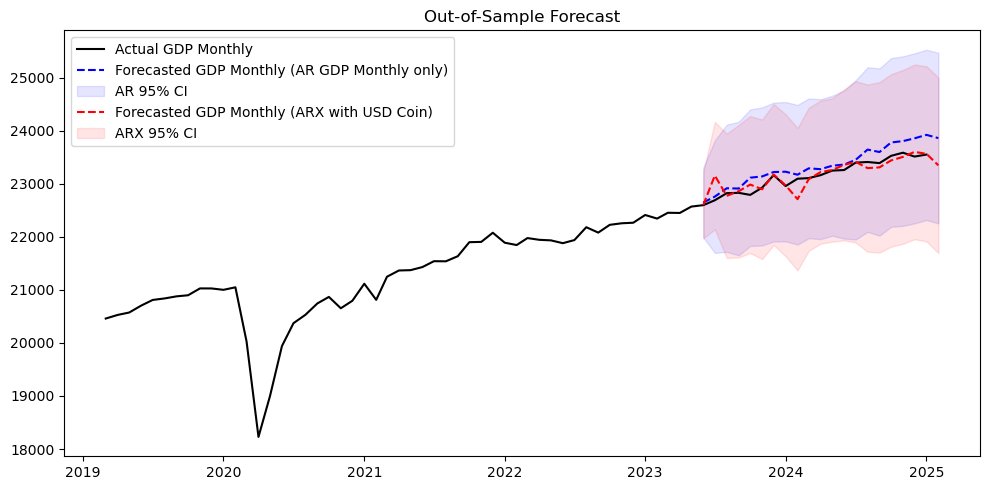

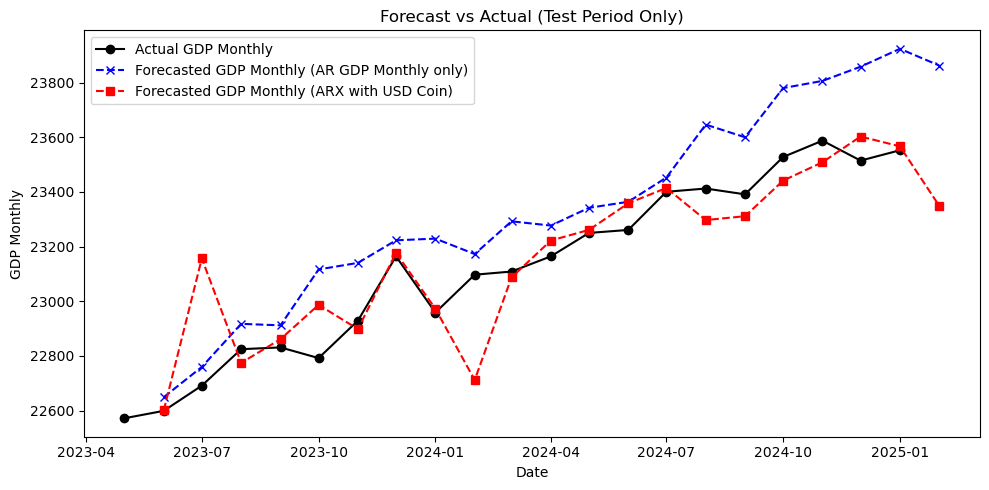

AR model test set evaluation:
  MAE:  223.6597
  RMSE: 242.9451
  R²:   0.4112
  MAPE:  0.9651%

ARX model test set evaluation:
  MAE:  127.7356
  RMSE: 174.6984
  R²:   0.6955
  MAPE:  0.5551%


In [148]:
df_temp = df[[macro, asset]].dropna().copy()

### new
df_temp['asset_lag1'] = df_temp[asset].shift(1)  # t-1
df_temp['asset_lag2'] = df_temp[asset].shift(2)  # t-2 (optional)
df_temp = df_temp.dropna()

target = df_temp[macro]
# exog = df_temp[[asset]]

# exog = df_temp[[asset, 'asset_lag1']].dropna()
exog = df_temp[[asset, 'asset_lag1','asset_lag2']].dropna()
# exog = df_temp[[asset, 'LFPR', 'r']].dropna()


# Train/test split
train_endog = target[:train_end]
train_exog = exog[:train_end]
test_endog = target[train_end:]
test_exog = exog[train_end:]

order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
p = order_dict['p']
q = order_dict['q']

# AR model
ar_model = SARIMAX(train_endog, order=(p, 1, q), seasonal_order=(1, 1, 0, 12))
ar_result = ar_model.fit(disp=False)
forecast_ar = ar_result.get_forecast(steps=len(test_endog))
pred_ar = forecast_ar.predicted_mean
conf_int_ar = forecast_ar.conf_int() 

# ARX model
arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 1, q), seasonal_order=(1, 1, 0, 12))
arx_result = arx_model.fit(disp=False)
forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
pred_arx = forecast_arx.predicted_mean
conf_int_arx = forecast_arx.conf_int()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro, color = 'black')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', color = 'blue')
plt.fill_between(
    pred_ar.index,
    conf_int_ar.iloc[:, 0],  # Lower bound
    conf_int_ar.iloc[:, 1],   # Upper bound
    color='blue',
    alpha=0.1,
    label='AR 95% CI'
)
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color = 'red')
plt.fill_between(
    pred_arx.index,
    conf_int_arx.iloc[:, 0],  # Lower bound
    conf_int_arx.iloc[:, 1],  # Upper bound
    color='red',
    alpha=0.1,
    label='ARX 95% CI'
)
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# print(ar_result.summary())
# print(arx_result.summary())

# Printing stats 
mae_ar = mean_absolute_error(test_endog, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_endog, pred_ar))
r2_ar = r2_score(test_endog, pred_ar)
mape_ar = mean_absolute_percentage_error(test_endog, pred_ar)

mae_arx = mean_absolute_error(test_endog, pred_arx)
rmse_arx = np.sqrt(mean_squared_error(test_endog, pred_arx))
r2_arx = r2_score(test_endog, pred_arx)
mape_arx = mean_absolute_percentage_error(test_endog, pred_arx)

# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o', color = 'black')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x', color = 'blue')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s', color = 'red')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}")
print(f"  MAPE:  {mape_ar:.4%}\n")


print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")
print(f"  MAPE:  {mape_arx:.4%}")
